# Part 1 : Collecting the data of the songs
## Import libraries

In [1]:
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import requests
import pandas as pd
import time
import traceback
import logging
import numpy as np
import pickle
from IPython.display import IFrame
from sklearn import datasets # sklearn comes with some toy datasets to practise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Spotify API

In [2]:
import config
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id,
                                                           client_secret= config.client_secret))

## Get tracks from a playlist

In [19]:
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id,market="GB")
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks


## Get playlists by categories 
# get all category IDs

AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': config.client_id,
    'client_secret': config.client_secret,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

# request and store results in json
url = "https://api.spotify.com/v1/browse/categories"
re = requests.get(url, headers = headers)
results = re.json()
results = results['categories']
# print(results)
categories = results['items']
while results['next']:
        results = sp.next(results)
        results = results['categories']
        categories.extend(results['items'])


################################
# put all category ids into a list
categories_list = [categories[i]['id'] for i in range(len(categories))]


# loop thru categories 
# create an empty list to store playlists
playlist_cat = []

for category in categories_list:
    try:
        # print(category)
        playlist_by_cat_url = "https://api.spotify.com/v1/browse/categories/{category_id}/playlists".format(category_id = category)
        playlist_by_cat = requests.get(playlist_by_cat_url, headers= headers)
        re = playlist_by_cat.json()
        results = re['playlists']
        playlist = results['items']
        while results['next']:
            results = sp.next(results)
            results = results['playlists']
            playlist.extend(results['items'])
        playlists = [playlist[i]["id"] for i in range(len(playlist)) if playlist[i] is not None]
        # print('current list length ', len(playlists))
        playlist_cat.append(playlists)
        # print('total length of list: ', len(playlist_list))
        # print(playlists)
    except KeyError:
        continue

# get the nested lists out
playlist_cat = [i for j in playlist_cat for i in j]
# remove duplicates
playlist_cat = list(set(playlist_cat))


In [5]:
############################################
# get playlists from spotify featured list
############################################
playlist_featured = []
spotify_url = "https://api.spotify.com/v1/users/spotify/playlists"
spotify_list = requests.get(spotify_url, headers= headers)
results = spotify_list.json()
print(results['total'])
playlist_featured = results['items']
while results['next']:
    results = sp.next(results)
    playlist_featured.extend(results['items'])

print(len(playlist_featured))

# get playlist ids from dict
playlist_featured = [playlist_featured[i]['id'] for i in range(len(playlist_featured))]
playlist_featured = list(set(playlist_featured))

1147
1146


In [6]:
#### Code for multi playlist
playlist_list_1 = ["3aO5XVSdM5iBr9i4pIABfx","0twlW4iDRhKXAJPopD8PP0","37i9dQZF1DXacPj7eARo6k","4DqrCY5HkSMxKvteqA3Gr1","2hX5NtjkjfTqVqSTv2NMQq",
"2xprAOAO0bPjec45puo08f","0xDxPGwSTcjEHurxow979h","1xNWydoMmA8210KeHU948w","31ymdYCITDnZRtkKzP3Itp","005Yej0r8xcIiwXzzdGWpm","1C49yxU1XBkoq5yaVDbJwx","69fEt9DN5r4JQATi52sRtq"]
# combine all the lists
playlist_list = playlist_cat + playlist_featured + playlist_list_1
# remove duplicates
playlist_list = list(set(playlist_list))
tracks_all = []

# just curious how long it would take to fetch all data
start_time = time.time()
for i in playlist_list:
    tracks=get_playlist_tracks("spotify", i)
    tracks_all.extend(tracks)
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))
len(tracks_all)

--- 633.056524515152 seconds ---


263122

In [7]:
songs_id = [tracks_all[i]['track']['id'] for i in range(0,len(tracks_all)) if tracks_all[i]['track'] is not None]
print(len(songs_id))
songs_id = list(set(songs_id))
print(len(songs_id))


263063
172591


In [15]:
list_of_audio_features=[]

start_time = time.time()

counter = 0
for song_id in songs_id:
    try:
        features = sp.audio_features(song_id)[0]
        if features is not None:
            list_of_audio_features.append(features)
    except TypeError:
        continue
    # try again if Readtime Error
    except requests.exceptions.Timeout:
        try:
            features = sp.audio_features(song_id)[0]
            if features is not None:
                list_of_audio_features.append(features)
        except TypeError:
            continue
        # if still error, print and move on
        except requests.exceptions.Timeout as e:
            logging.error(traceback.format_exc())
    # try to catch all other errors to prevent loss
    except Exception as e:
        logging.error(traceback.format_exc())
    # update progress
    counter += 1
    if counter % 1000 == 0:
        # exporty every 1000 rows to prevent loss
        df=pd.DataFrame(list_of_audio_features)    
        df=df[["danceability","energy","loudness","speechiness","acousticness", "instrumentalness","liveness","valence","tempo","id","duration_ms"]]
        df.to_csv('audio_features.csv')
        timer = time.time()
        print(counter,'of', len(songs_id), 'rows processed')
        print("--- %s seconds ---" % (timer - start_time))


        
end_time = time.time()
print("--- %s seconds ---" % (end_time - start_time))

df=pd.DataFrame(list_of_audio_features)    
df=df[["danceability","energy","loudness","speechiness","acousticness",
    "instrumentalness","liveness","valence","tempo","id","duration_ms"]]
print(df.shape[0])
df.drop_duplicates()
print(df.shape[0])
df.to_csv('audio_features.csv', index = False)

1000 of 172591 rows processed
--- 85.34409928321838 seconds ---
2000 of 172591 rows processed
--- 184.9259114265442 seconds ---
3000 of 172591 rows processed
--- 285.0246844291687 seconds ---
4000 of 172591 rows processed
--- 385.01889729499817 seconds ---
5000 of 172591 rows processed
--- 484.58047366142273 seconds ---
6000 of 172591 rows processed
--- 584.7573990821838 seconds ---
7000 of 172591 rows processed
--- 684.3960857391357 seconds ---
8000 of 172591 rows processed
--- 784.442948102951 seconds ---
9000 of 172591 rows processed
--- 884.9025475978851 seconds ---
10000 of 172591 rows processed
--- 983.9977738857269 seconds ---
11000 of 172591 rows processed
--- 1083.9440393447876 seconds ---
12000 of 172591 rows processed
--- 1183.9148879051208 seconds ---
13000 of 172591 rows processed
--- 1276.4365701675415 seconds ---
14000 of 172591 rows processed
--- 1375.5902388095856 seconds ---
15000 of 172591 rows processed
--- 1476.2344686985016 seconds ---
16000 of 172591 rows process

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,0.415,0.0648,-21.435,0.0339,0.980000,0.931000,0.1210,0.0761,100.738,218Yeqib6escXVrGVq8xLf,170743
1,0.741,0.3980,-9.472,0.0522,0.641000,0.000110,0.1040,0.2830,117.871,0Y3HMB9SilcStmngwA0wMt,294915
2,0.296,0.9250,-0.783,0.0767,0.001280,0.000315,0.0797,0.6070,204.111,5g0HSob4PEq7M8blV6y70i,162600
3,0.631,0.7360,-6.960,0.0682,0.033600,0.012400,0.3000,0.6450,95.091,7e24AU1oA4X7rNNNVhsKGD,212293
4,0.785,0.8350,-6.775,0.0464,0.006660,0.007780,0.3770,0.6630,123.967,1FkMXuvNvdvaIqZ034viGa,161311
...,...,...,...,...,...,...,...,...,...,...,...
171897,0.122,0.0839,-15.863,0.0392,0.866000,0.783000,0.1050,0.1110,76.439,2xemktJsTw9werdDf6jWCO,333893
171898,0.683,0.6910,-4.948,0.0330,0.339000,0.000000,0.2100,0.6560,139.958,5ZSAw7nOCmEviSozvHTGUH,167143
171899,0.214,0.2430,-17.301,0.0319,0.917000,0.912000,0.0657,0.0381,80.187,1QwnjxsFzruTTCbuuKQdnH,176062
171900,0.441,0.7860,-6.906,0.1360,0.070600,0.009010,0.1300,0.3520,138.016,3zJ9Sn4QvlrR7winvdyTCu,251389


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
id,,,,,,,,,,
218Yeqib6escXVrGVq8xLf,0.415,0.0648,-21.435,0.0339,0.98000,0.931000,0.1210,0.0761,100.738,170743
0Y3HMB9SilcStmngwA0wMt,0.741,0.3980,-9.472,0.0522,0.64100,0.000110,0.1040,0.2830,117.871,294915
5g0HSob4PEq7M8blV6y70i,0.296,0.9250,-0.783,0.0767,0.00128,0.000315,0.0797,0.6070,204.111,162600
7e24AU1oA4X7rNNNVhsKGD,0.631,0.7360,-6.960,0.0682,0.03360,0.012400,0.3000,0.6450,95.091,212293
1FkMXuvNvdvaIqZ034viGa,0.785,0.8350,-6.775,0.0464,0.00666,0.007780,0.3770,0.6630,123.967,161311


,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,-0.711998,-1.668206,-1.388403,-0.505222,1.581885,1.777421,-0.384925,-1.357333,-0.558347,-0.440853
1,0.943437,-0.502280,0.181978,-0.327131,0.657516,-0.673201,-0.495106,-0.588449,0.001107,0.600931
2,-1.316282,1.341786,1.322582,-0.088705,-1.086842,-0.672662,-0.652599,0.615604,2.817153,-0.509172
3,0.384855,0.680442,0.511728,-0.171424,-0.998713,-0.640847,0.775212,0.756820,-0.742742,-0.092255
4,1.166870,1.026860,0.536013,-0.383575,-1.072172,-0.653010,1.274265,0.823712,0.200163,-0.519986


Training a K-Means model with 2 clusters! 

Training a K-Means model with 3 clusters! 

Training a K-Means model with 4 clusters! 

Training a K-Means model with 5 clusters! 

Training a K-Means model with 6 clusters! 

Training a K-Means model with 7 clusters! 

Training a K-Means model with 8 clusters! 

Training a K-Means model with 9 clusters! 

Training a K-Means model with 10 clusters! 

Training a K-Means model with 11 clusters! 

Training a K-Means model with 12 clusters! 

Training a K-Means model with 13 clusters! 

Training a K-Means model with 14 clusters! 

Training a K-Means model with 15 clusters! 

Training a K-Means model with 16 clusters! 

Training a K-Means model with 17 clusters! 

Training a K-Means model with 18 clusters! 

Training a K-Means model with 19 clusters! 

Training a K-Means model with 20 clusters! 



Text(0.5, 1.0, 'Elbow Method showing the optimal k')

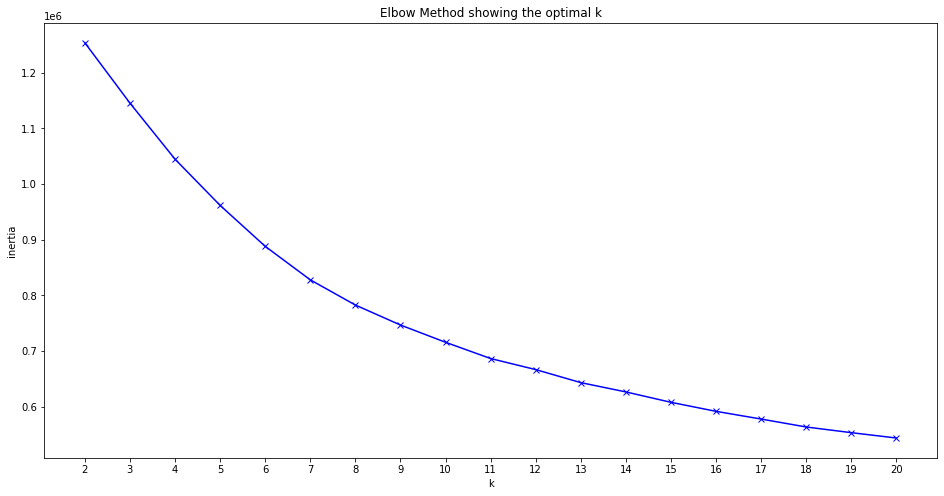

In [3]:
# import the audio feature dataframe

df = pd.read_csv('audio_features.csv')
# normalize audio features with scaler
X = df.set_index('id')
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)
display(X.head())
print()
display(X_scaled_df.head())

# save scaler using pickle
with open("Model/scaler.pickle", "wb") as f:
    pickle.dump(scaler,f)

# find optimal k using elbow method
K = range(2,21)
inertia = []
for k in K:
    print("Training a K-Means model with {} clusters! ".format(k))
    print()
    kmeans = KMeans(n_init = 10,
                    n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    inertia.append(kmeans.inertia_)

# plot out k-inertia
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

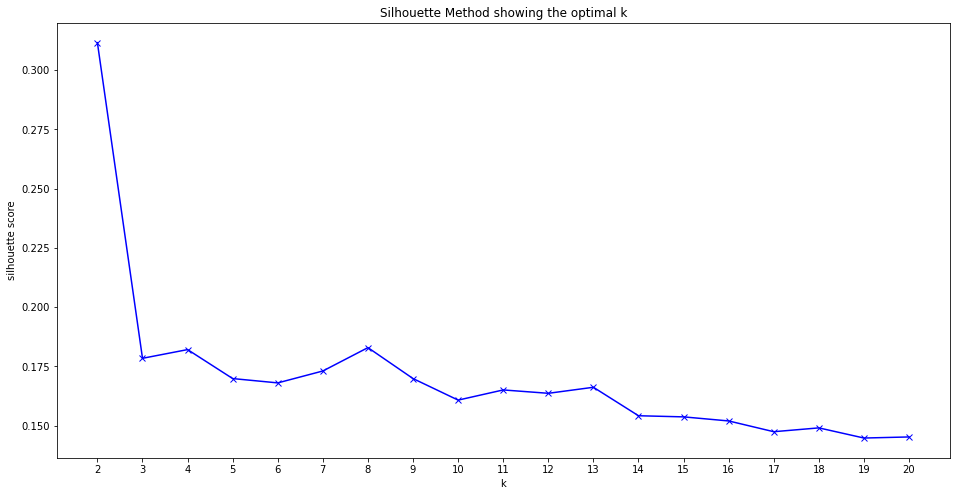

In [4]:
# find optimal k using silouhette method
K = range(2,21)
silhouette = []

for k in K:
    # print(k)
    kmeans = KMeans(n_init = 10,
                    n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_scaled_df)
    
    filename = "Model/kmeans_" + str(k) + ".pickle"
    with open(filename, "wb") as f:
        pickle.dump(kmeans,f)
    # print('pickle exported')

    silhouette.append(silhouette_score(X_scaled_df, kmeans.predict(X_scaled_df)))
    # print('predicted')

# plot out k-silhouette
plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')


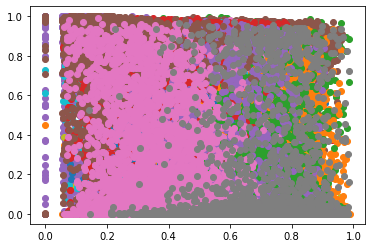

In [5]:
# cluster with optimal k
#TODO: verify final k
k = 18
kmeans = KMeans(n_init = 10, n_clusters=k, random_state=1234)
kmeans.fit(X_scaled_df)

# assign a cluster to each example
labels = kmeans.predict(X_scaled_df)
# retrieve unique clusters
clusters = np.unique(labels)
# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = np.where(labels == cluster)
    # create scatter of these samples
    plt.scatter(X.to_numpy()[row_ix, 0], X.to_numpy()[row_ix,5])
    # show the plot
plt.show()


In [6]:
# assign clusters to original df
clusters = kmeans.predict(X_scaled_df)
X["cluster"] = clusters

# save the model with optimal k
with open("Model/final_model.pickle", "wb") as f:
    pickle.dump(kmeans,f)

In [7]:
##############################
##### Song Recommender #######
##############################


## Song recommendation function
def get_song():
    song_name= input("Please enter the song name: ")

    ## Find the id of the song

    song_input = sp.search(q=song_name,limit=3,market="GB")
    # song_id = song['tracks']['items'][0]['id']
    song = song_input['tracks']['items']
    for i in range(len(song)):
        song_info = song[i]['name'] +' by ' + song[i]['artists'][0]['name']
        print(f'{i+1}. ',song_info)

    song_ind = input("Found several songs, please enter the number of the correct song: ")
    song_ind_int = int(song_ind)-1
    song_id = song[song_ind_int]['id']

    return song_id
    ## Song playing function
def play_song(track_id):
    return IFrame(src="https://open.spotify.com/embed/track/"+track_id,
    width="320",
    height="80",
    frameborder="0",
    allowtransparency="true",
    allow="encrypted-media",
    )


def get_rec_song():
    # get audio feature of the song
    audio_feature = sp.audio_features(input_song)

    # put it into dataframe
    song_feature=pd.DataFrame(audio_feature)  
    song_feature=song_feature[["danceability","energy","loudness","speechiness","acousticness",
        "instrumentalness","liveness","valence","tempo","id","duration_ms"]]
    song_feature.set_index("id",inplace=True)

    # Load the scaler
    def load(filename = "filename.pickle"): 
        try: 
            with open(filename, "rb") as f: 
                return pickle.load(f) 
            
        except FileNotFoundError: 
            print("File not found!") 
            
    scaler2 = load("Model/scaler.pickle")
    
    # Scale the new song
    song_scaled=scaler2.transform(song_feature)

    # get label of new song
    label_song =kmeans.predict(song_scaled) 

    # return a random song in the cluster
    filtered_song = X[X['cluster'] == label_song[0]]
    recommended_song = filtered_song.sample(n=3)

    # play the recommended song

    return recommended_song.index


In [8]:
# Control panel

input_song = get_song()
display(play_song(input_song))

rec_songs = get_rec_song()
print('Guess you also like:')
for i in rec_songs:
    
    display(play_song(i))

Please enter the song name: hello
1.  Hello by Adele
2.  Hello by Martin Solveig
3.  Hello (feat. A Boogie Wit da Hoodie) by Pop Smoke
Found several songs, please enter the number of the correct song: 1


Guess you also like:
